# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [6]:
df_reviews.isna().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

In [7]:
df_reviews.duplicated().sum()

0

There is over 47,000 entries in this dataset. There are objects, integers, and floats all in the dataframe. There are some missing values but they should not effect the outcome. There are zero duplicates in the dataset. 

## EDA

Let's check the number of movies and reviews over years.

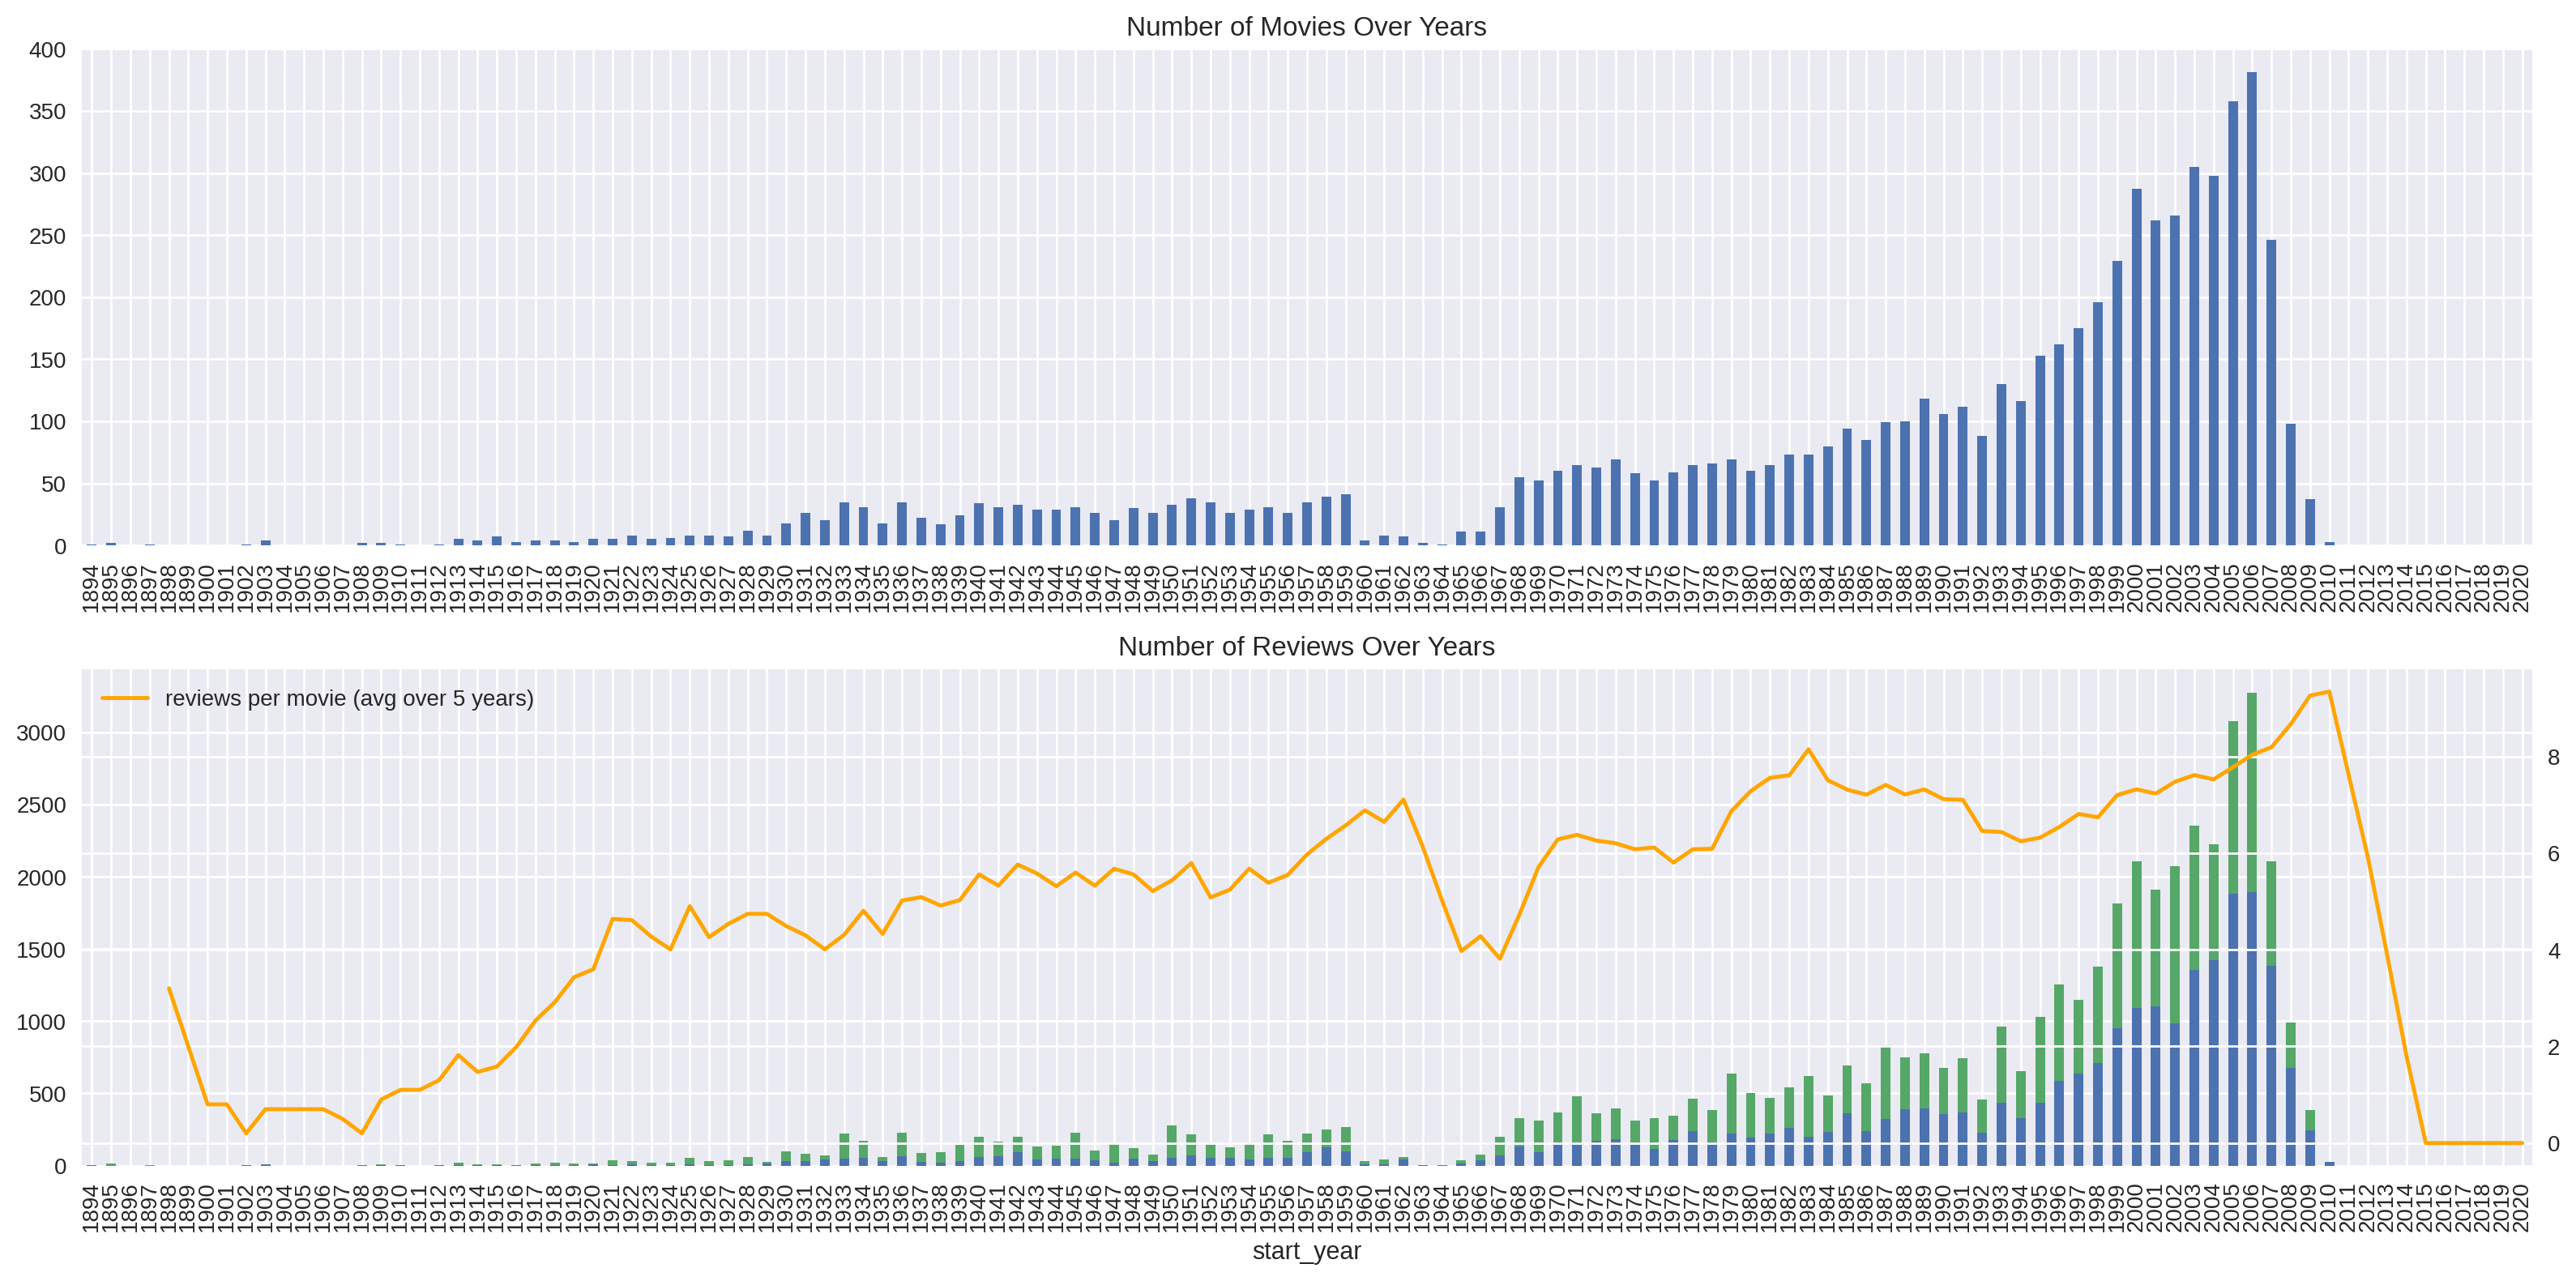

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

The two charts show the number of movies over the years and the number of reviews over the years. A potential relationship between the number of movies produced and the volume of reviews might exist. Over time, the growing number of reviews per movie may reflect the technology that is coming about. The balance between the positive and negative reviews can highlight shifts in audience perception or review behaviors from different eras. 

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

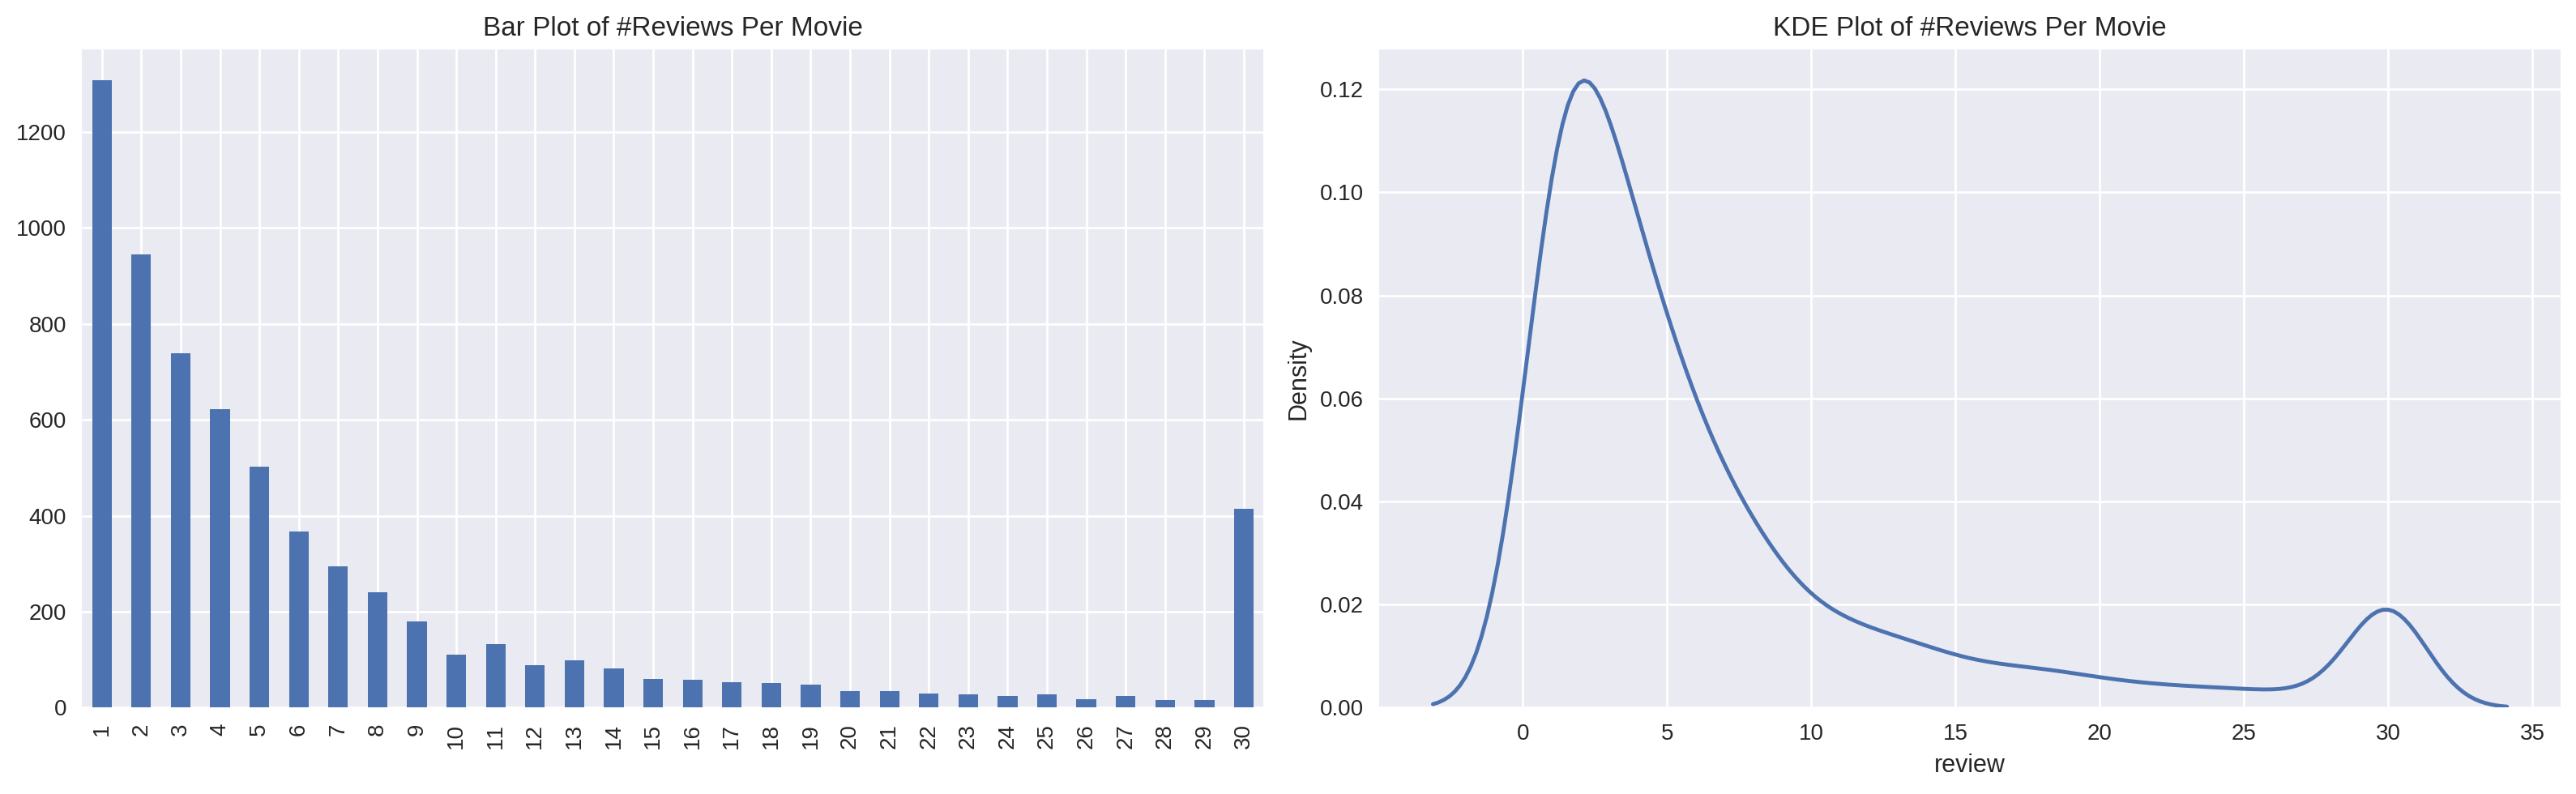

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

The code above visualizes the distribution of the number of reviews per movies in a bar plot and a KDE plot. In my personal opinion, we have a peak because it represents the most common review count per movie. The peak reflects that the majority of movies receive only a small number of reviews, while a minority of movies accumulate more reviews.

In [10]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

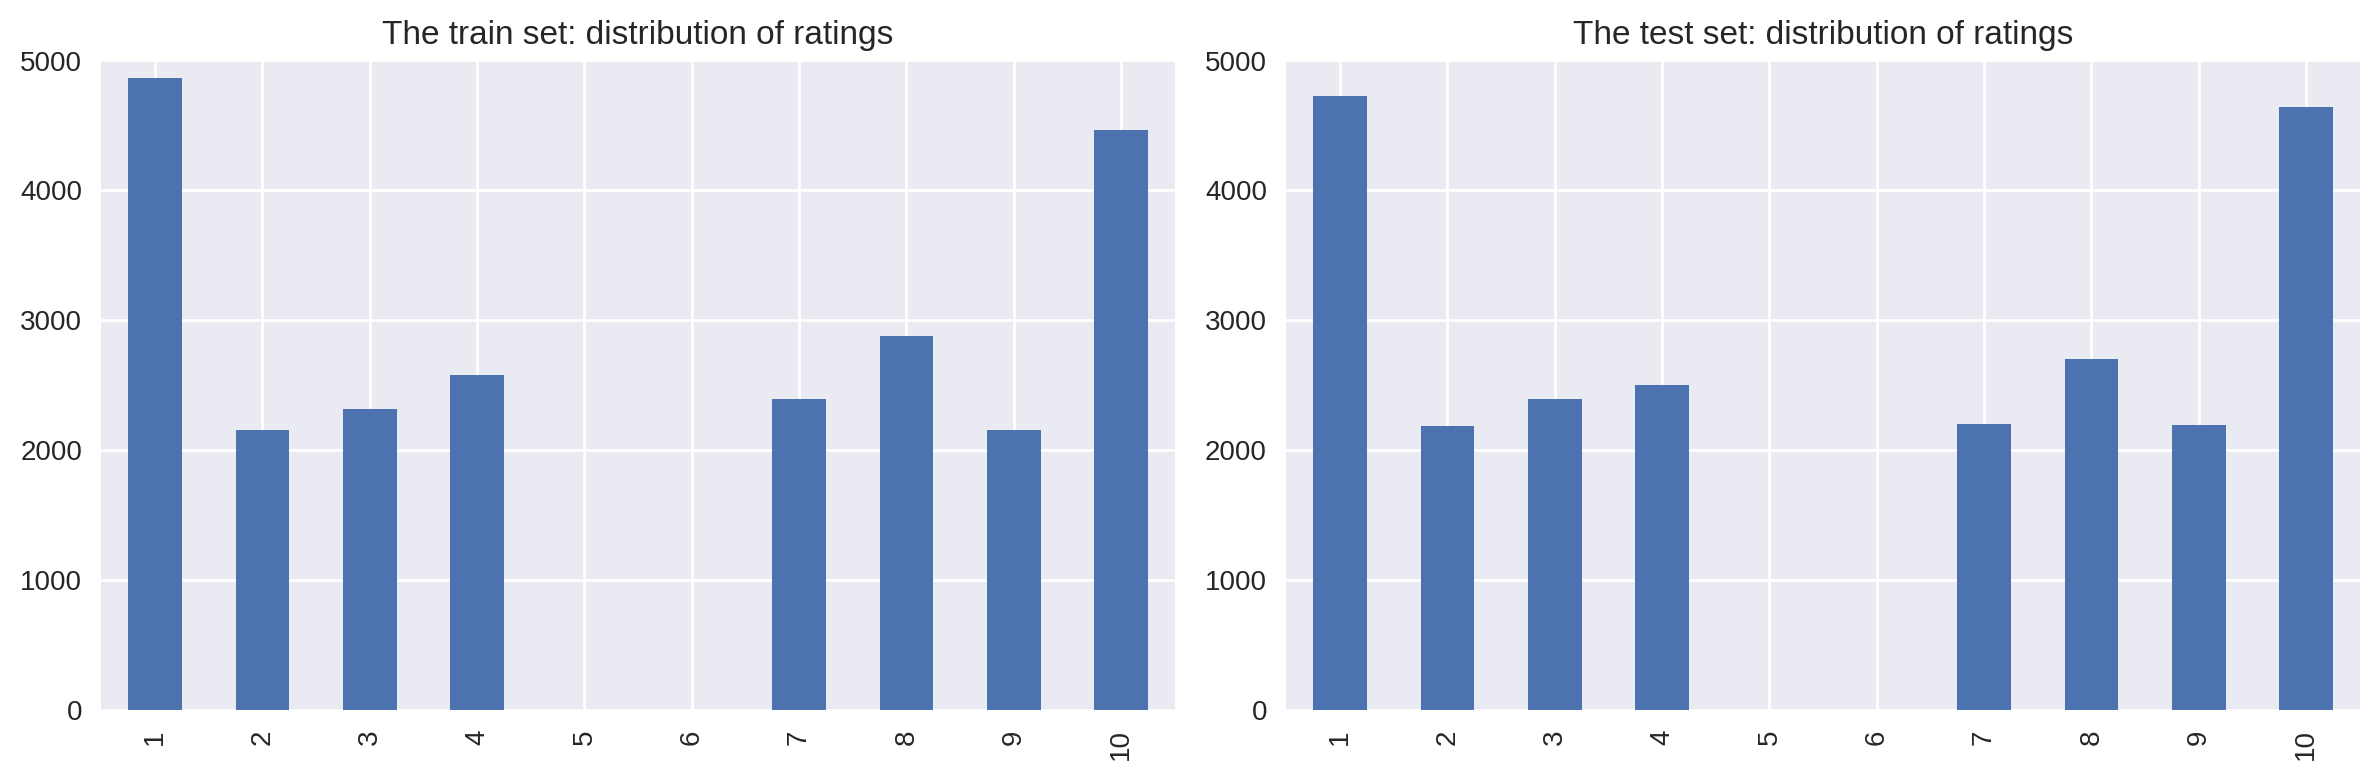

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

The charts above examines the fairness and representativeness of the train- test split for the rating variable. It ensures consistent distributions between the sets to avoid bias during model training and evaluation.

Distribution of negative and positive reviews over the years for two parts of the dataset

/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


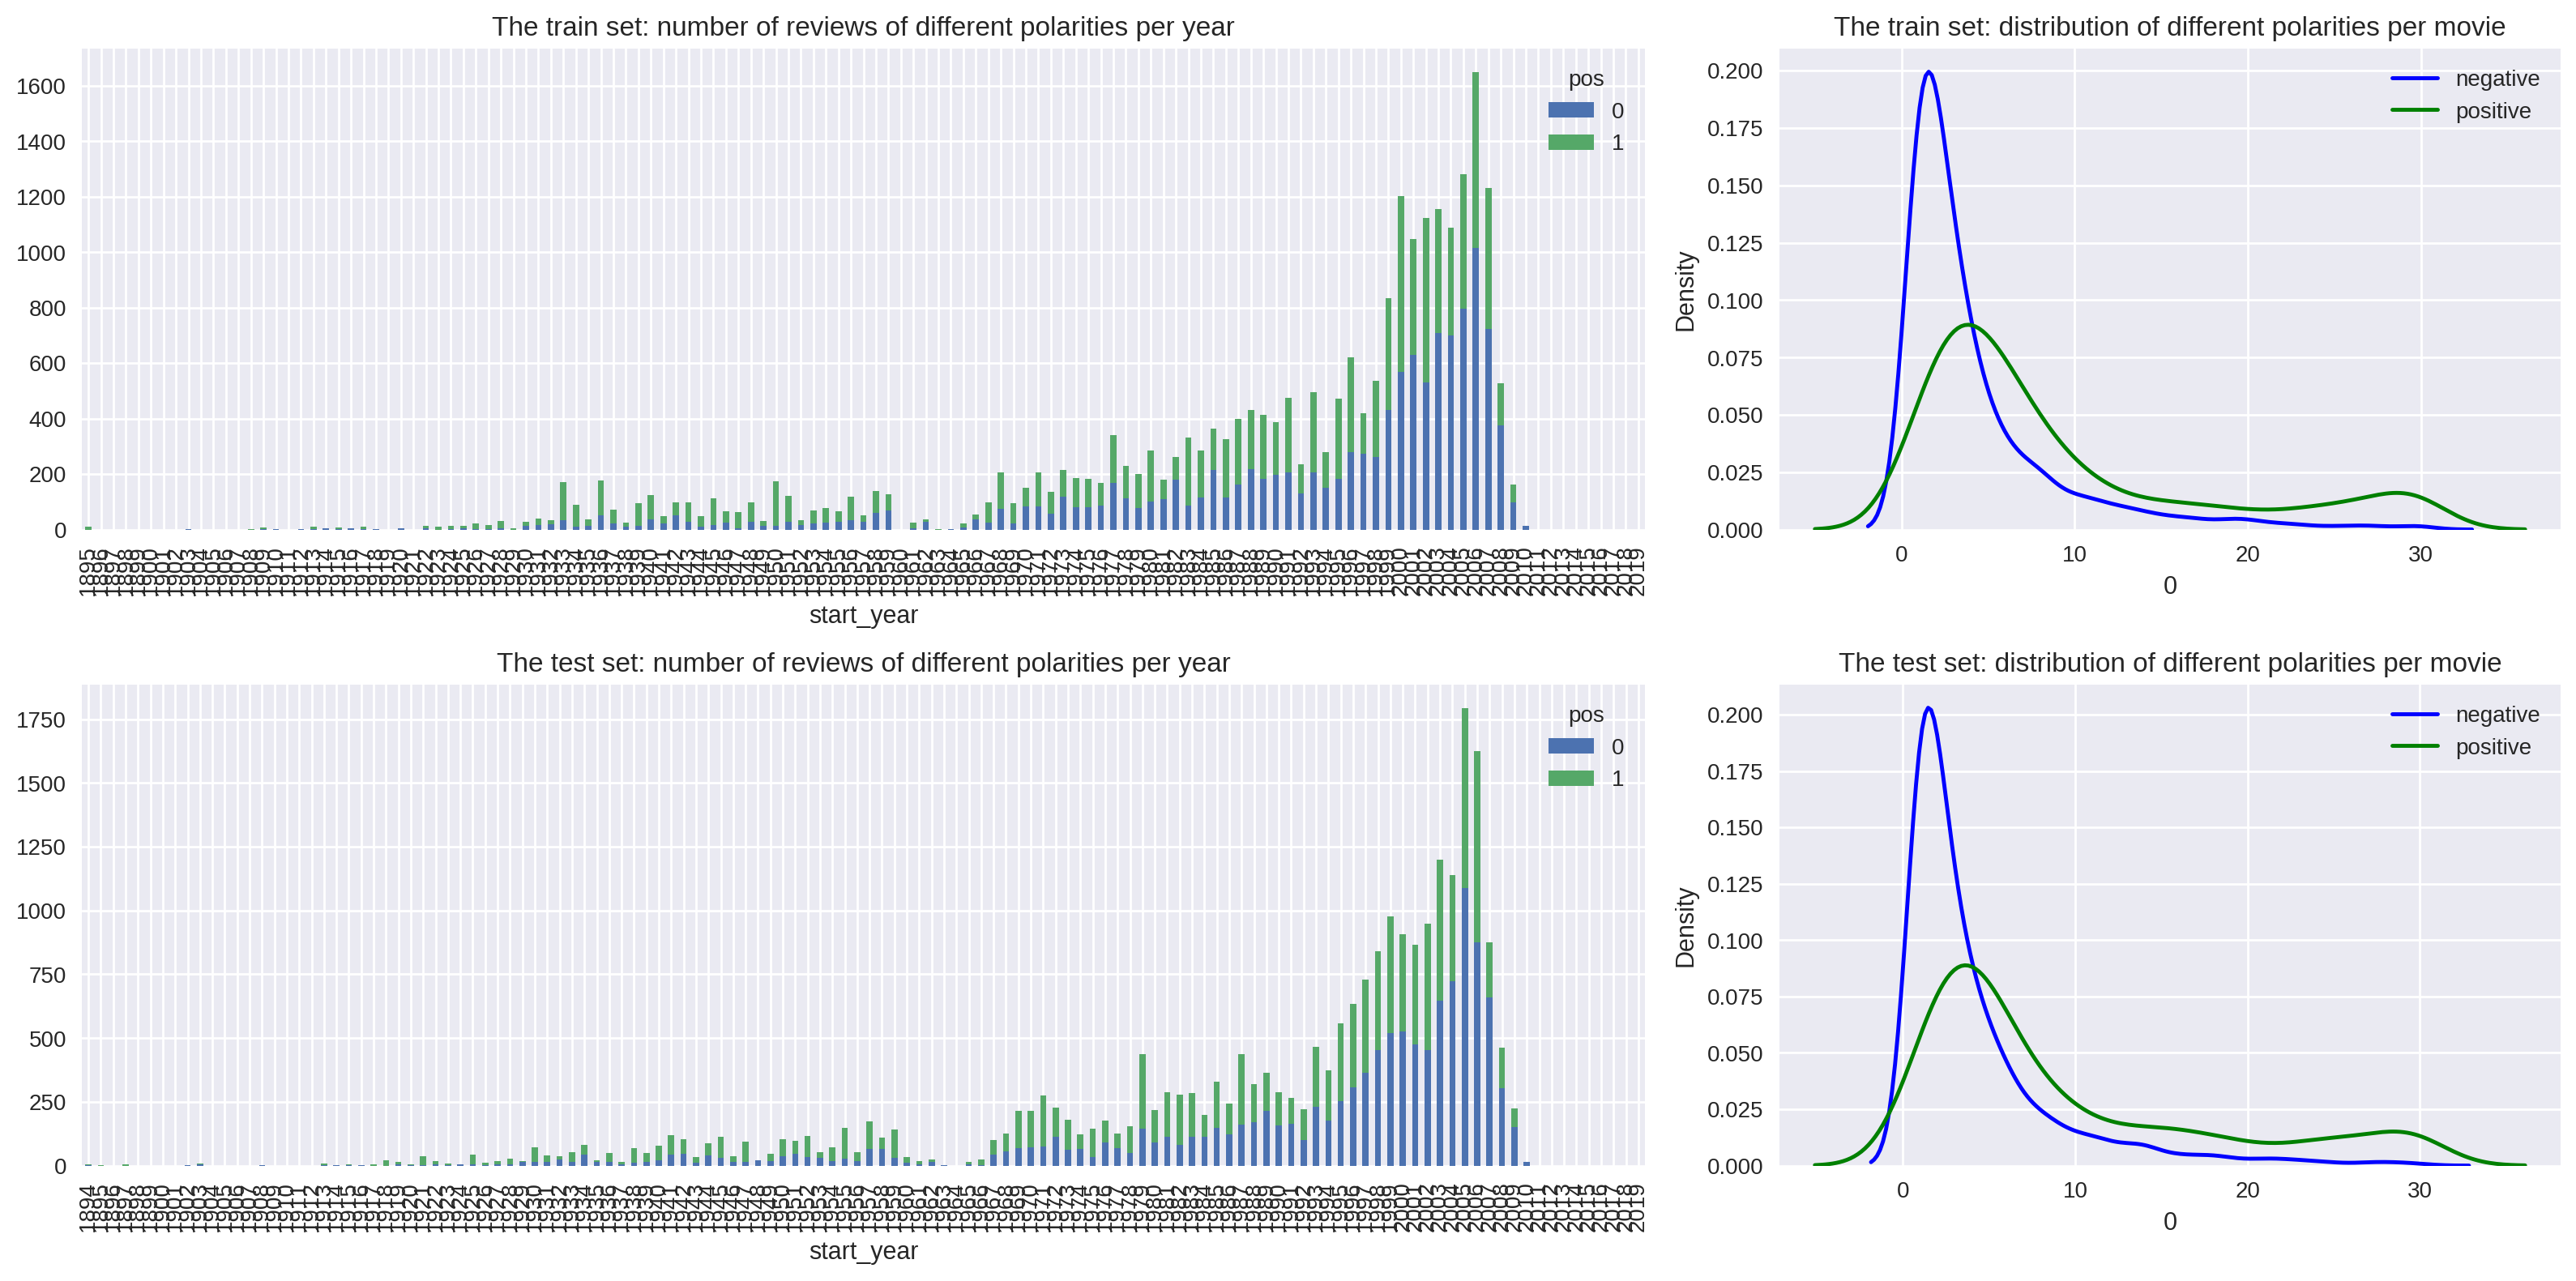

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

Peaks in the year- based bar plots indicate increased review activity during a specifc era that could potentially be ties to external events or growth in technology. KDE plots reveal whether reviews are skewed toward positivity or negativity - both within subsets.

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [13]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [14]:
import re

# Function to normalize text
def normalize_text(text):
    text = re.sub(r'\d+', '', text)  # remove digits
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    return text.lower()  # convert to lowercase

# Apply normalization to the 'review' column
df_reviews['review_norm'] = df_reviews['review'].apply(normalize_text)

display(df_reviews[['review', 'review_norm']].head())

,review,review_norm
0,The pakage implies that Warren Beatty and Gold...,the pakage implies that warren beatty and gold...
1,How the hell did they get this made?! Presenti...,how the hell did they get this made presenting...
2,There is no real story the film seems more lik...,there is no real story the film seems more lik...
3,Um .... a serious film about troubled teens in...,um a serious film about troubled teens in sin...
4,I'm totally agree with GarryJohal from Singapo...,im totally agree with garryjohal from singapor...


## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [15]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Working with models

### Model 0 - Constant

In [16]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, roc_auc_score

In [17]:
# initialize the DummyClassifier to make this the baseline model
dummy_constant = DummyClassifier(strategy='constant', constant=1, random_state=42)  

# train 
dummy_constant.fit(df_reviews_train.drop(columns=['pos', 'ds_part']), train_target)  

# predict 
train_predictions = dummy_constant.predict(df_reviews_train.drop(columns=['pos', 'ds_part']))
test_predictions = dummy_constant.predict(df_reviews_test.drop(columns=['pos', 'ds_part']))

# evaluate 
print("Dummy Classifier - Constant Strategy")


print("\nTrain Metrics:")
print(classification_report(train_target, train_predictions))


print("\nTest Metrics:")
print(classification_report(test_target, test_predictions))

# ROC AUC 
train_proba = dummy_constant.predict_proba(df_reviews_train.drop(columns=['pos', 'ds_part']))[:, 1]
test_proba = dummy_constant.predict_proba(df_reviews_test.drop(columns=['pos', 'ds_part']))[:, 1]

train_roc_auc = roc_auc_score(train_target, train_proba)
test_roc_auc = roc_auc_score(test_target, test_proba)

print(f"\nTrain ROC AUC: {train_roc_auc:.2f}")
print(f"Test ROC AUC: {test_roc_auc:.2f}")

Dummy Classifier - Constant Strategy

Train Metrics:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     11912
           1       0.50      1.00      0.67     11884

    accuracy                           0.50     23796
   macro avg       0.25      0.50      0.33     23796
weighted avg       0.25      0.50      0.33     23796


Test Metrics:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     11803
           1       0.50      1.00      0.67     11732

    accuracy                           0.50     23535
   macro avg       0.25      0.50      0.33     23535
weighted avg       0.25      0.50      0.33     23535


Train ROC AUC: 0.50
Test ROC AUC: 0.50


/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/python3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/python3/lib/

The purpose of the the dummy classifier is to provide a reference point to evaluate the models going forward. The baseline model doesn't look great, but it does highlight the lowest possible performance showing us that we need a more sophisticated model to improve metrics and performance. 

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [18]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [19]:
# download necessary NLTK resources
nltk.download('stopwords')

# define a function 
def preprocess_text(text):
    # tokenize and remove stopwords
    stop_words = set(stopwords.words('english'))
    words = nltk.word_tokenize(text.lower())  
    return ' '.join([word for word in words if word.isalnum() and word not in stop_words])

# preprocess reviews in train and test sets
df_reviews_train['review_norm'] = df_reviews_train['review'].apply(preprocess_text)
df_reviews_test['review_norm'] = df_reviews_test['review'].apply(preprocess_text)

# convert text into TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  

train_features_1 = tfidf_vectorizer.fit_transform(df_reviews_train['review_norm'])
test_features_1 = tfidf_vectorizer.transform(df_reviews_test['review_norm'])

# train the model
model_1 = LogisticRegression(max_iter=1000, random_state=42) 
model_1.fit(train_features_1, train_target)


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


LogisticRegression(max_iter=1000, random_state=42)

          train  test
Accuracy   0.92  0.88
F1         0.92  0.88
APS        0.97  0.95
ROC AUC    0.97  0.95


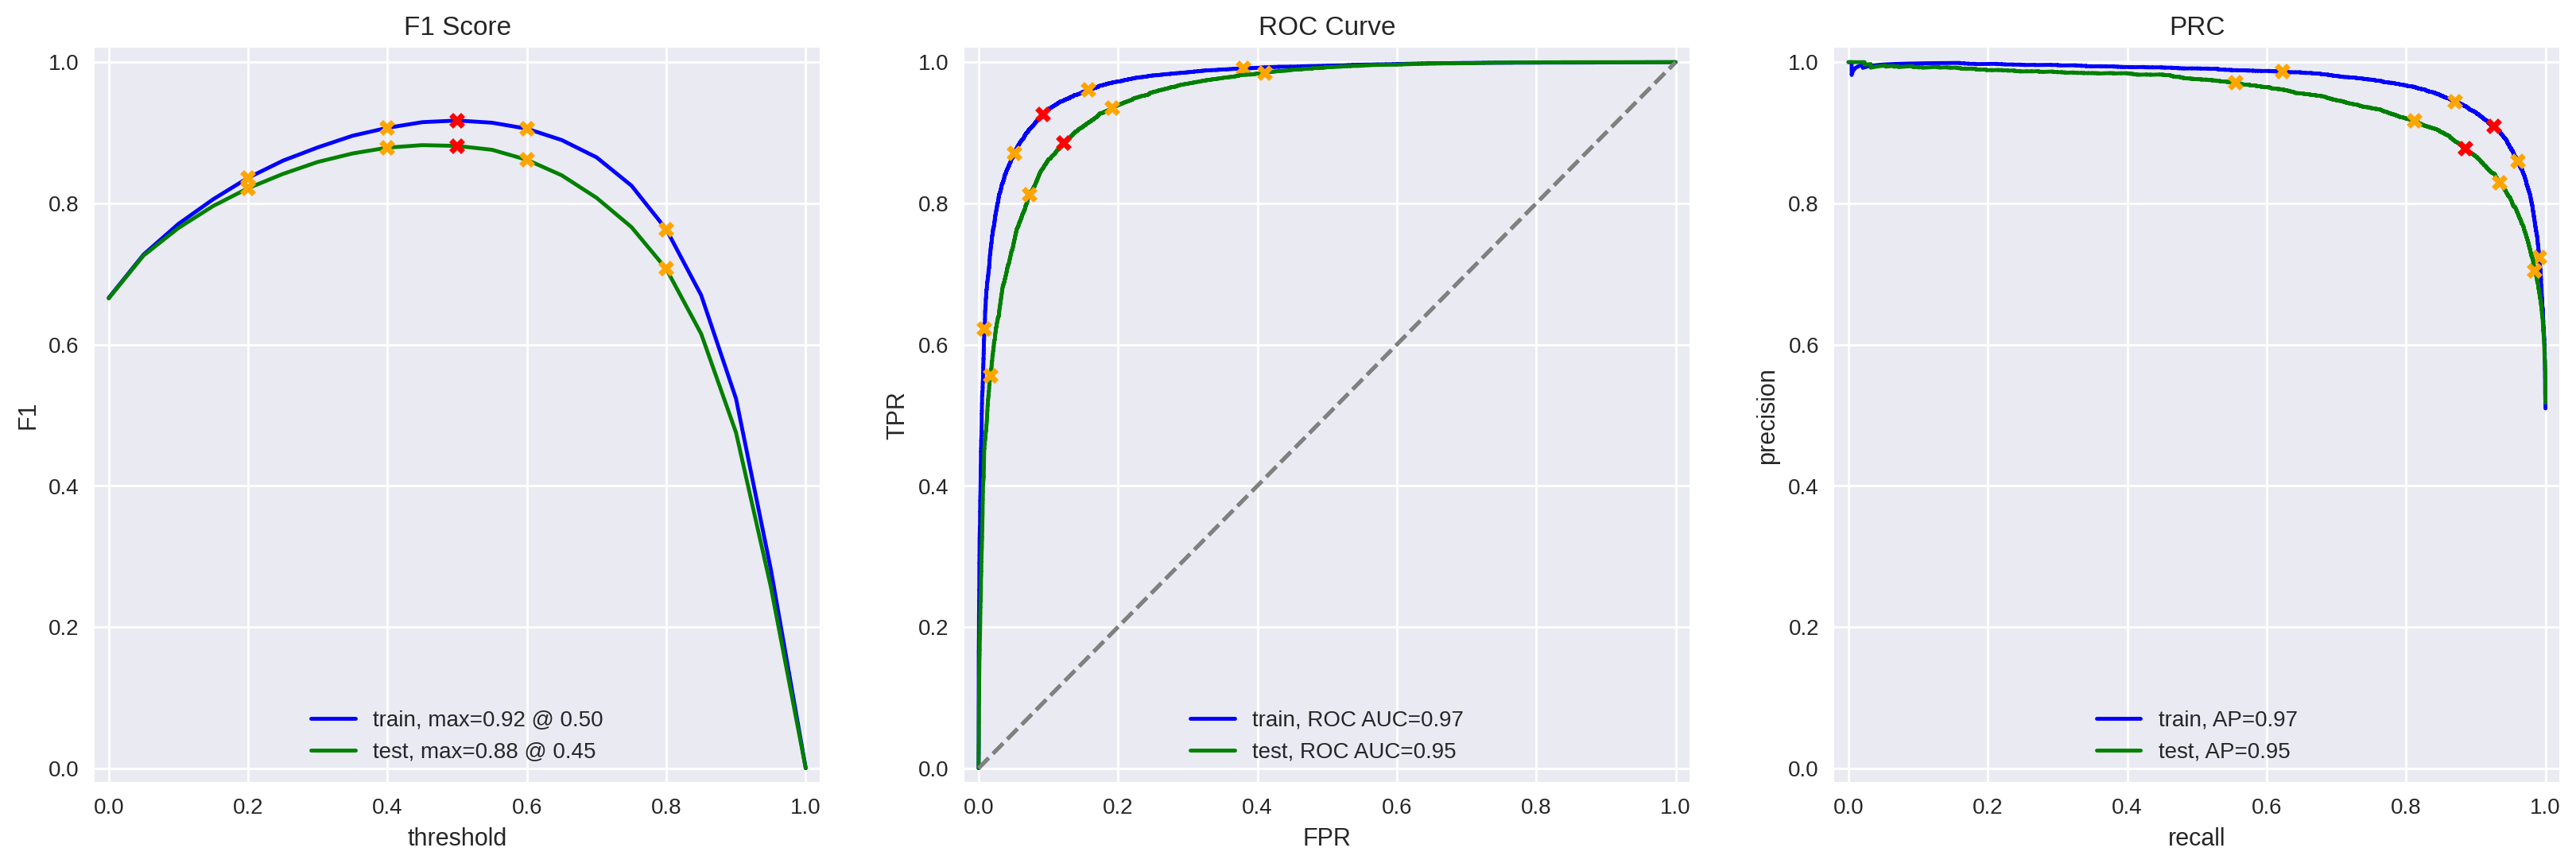

In [20]:
# evaluate model
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

### Model 2 - spaCy, TF-IDF and LR

In [21]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [22]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

          train  test
Accuracy   0.91  0.88
F1         0.91  0.88
APS        0.97  0.95
ROC AUC    0.97  0.95


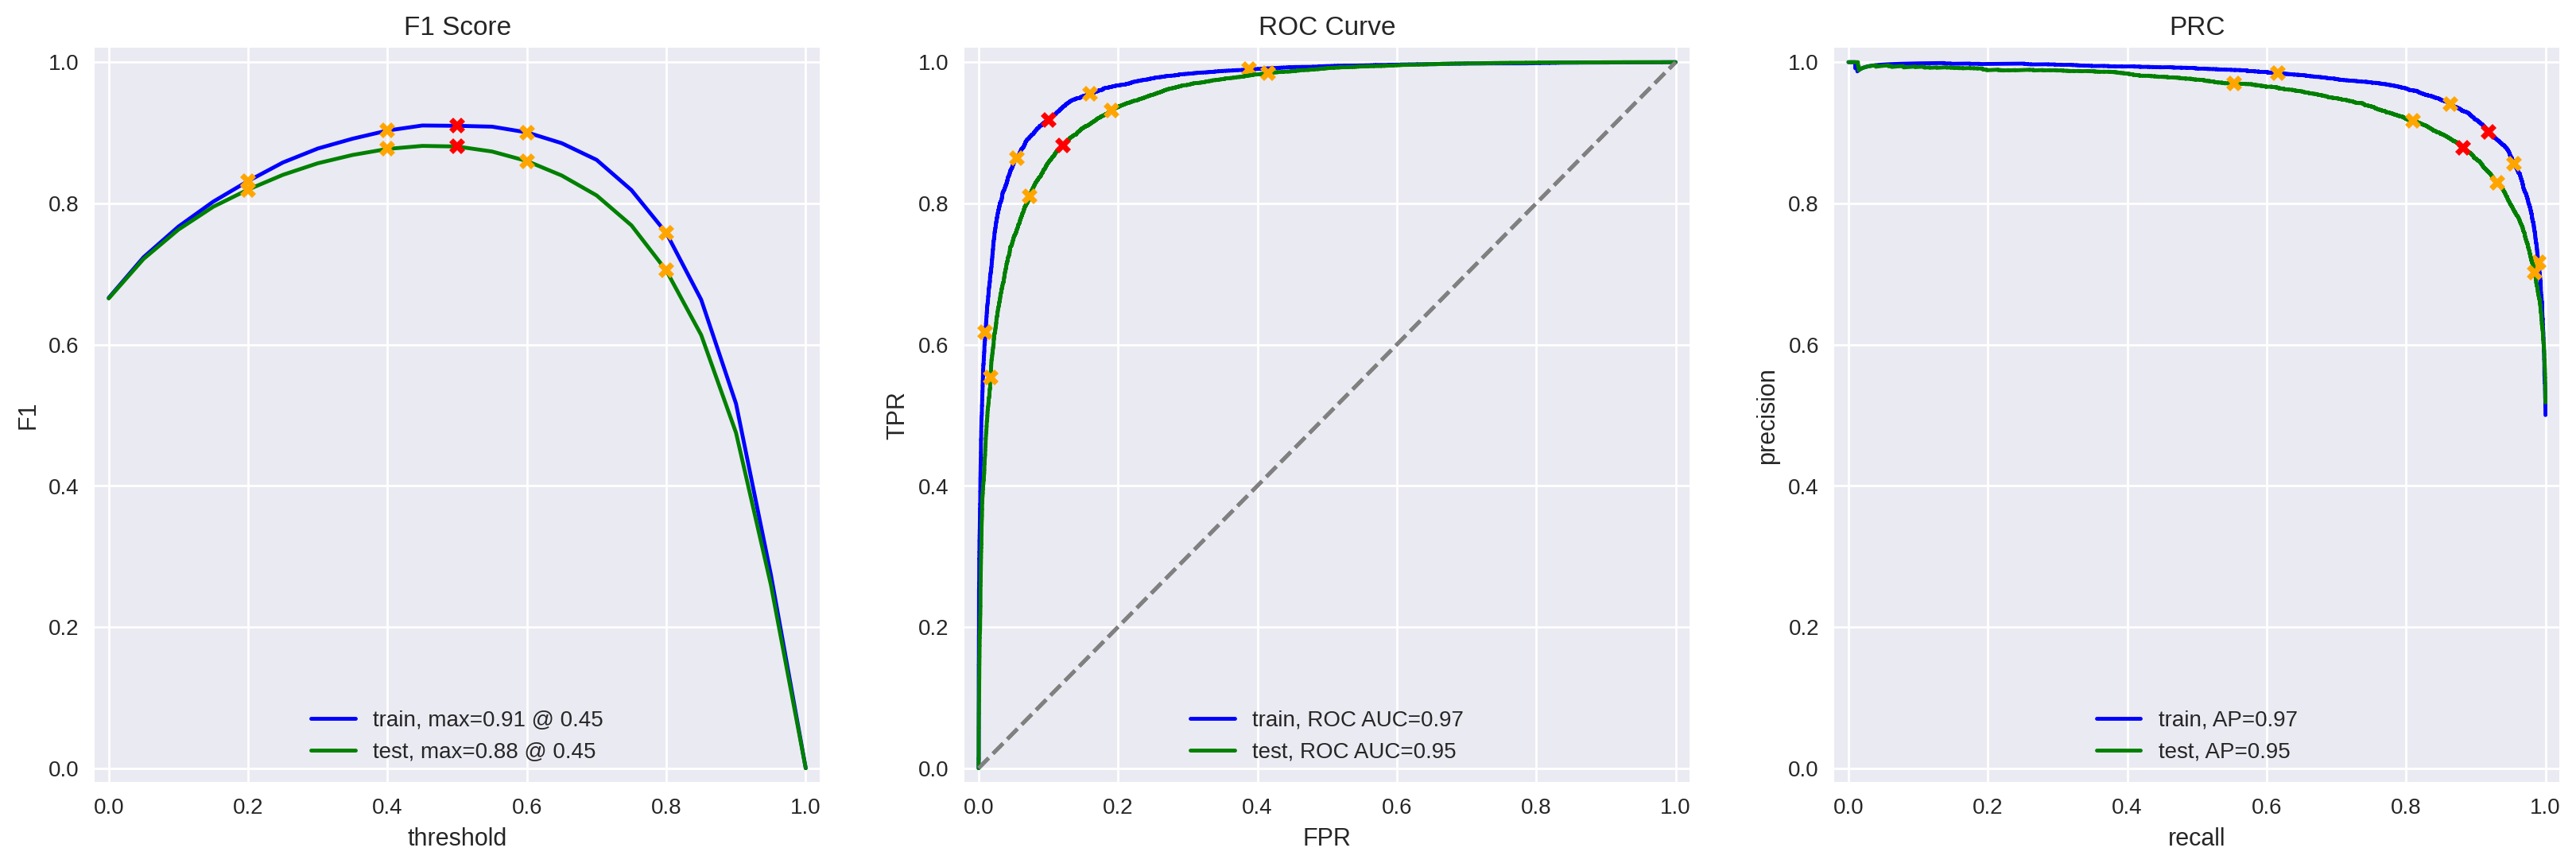

In [23]:
# preprocess the reviews 
df_reviews_train['review_norm'] = df_reviews_train['review'].apply(text_preprocessing_3)
df_reviews_test['review_norm'] = df_reviews_test['review'].apply(text_preprocessing_3)

# convert text into TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  

train_features_2 = tfidf_vectorizer.fit_transform(df_reviews_train['review_norm'])
test_features_2 = tfidf_vectorizer.transform(df_reviews_test['review_norm'])

# train the model
model_2 = LogisticRegression(max_iter=1000, random_state=42)  
model_2.fit(train_features_2, train_target)

# evaluate the model 
evaluate_model(model_2, train_features_2, train_target, test_features_2, test_target)

### Model 3 - spaCy, TF-IDF and LGBMClassifier

In [24]:
from lightgbm import LGBMClassifier

In [ ]:
# load spaCy's model
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# define a function to preprocess text 
def text_preprocessing_4(text):
    doc = nlp(text)
    # tokenizing and lemmatizing the text
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    
    return ' '.join(tokens)

# preprocess the reviews 
df_reviews_train['review_norm'] = df_reviews_train['review'].apply(text_preprocessing_4)
df_reviews_test['review_norm'] = df_reviews_test['review'].apply(text_preprocessing_4)

# convert text into TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  

train_features_3 = tfidf_vectorizer.fit_transform(df_reviews_train['review_norm'])
test_features_3 = tfidf_vectorizer.transform(df_reviews_test['review_norm'])

# train the LightGBM Classifier model
model_3 = LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42)  
model_3.fit(train_features_3, train_target)

# evaluate
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

In [ ]:
# normalize the my_reviews
my_reviews['review_norm'] = my_reviews['review'].apply(text_preprocessing_4) 
def make_predictions(vectorizer, model, reviews):
    review_features = vectorizer.transform(reviews['review_norm'])
    
    predictions = model.predict(review_features)
    probabilities = model.predict_proba(review_features)[:, 1]
    
    results = pd.DataFrame({
        'Review': reviews['review'],
        'Processed Review': reviews['review_norm'],
        'Prediction': predictions,
        'Probability': probabilities
    })
    
    return results

# apply vectorizers and models to reviews 
print("Logistic Regression with Lemmatization and TF-IDF")
results_model_1 = make_predictions(tfidf_vectorizer, model_1, my_reviews)
print(results_model_1)

print("\nLogistic Regression with Advanced Preprocessing and TF-IDF")
results_model_2 = make_predictions(tfidf_vectorizer, model_2, my_reviews)
print(results_model_2)

print("\nLightGBM Classifier with Advanced Preprocessing and TF-IDF")
results_model_3 = make_predictions(tfidf_vectorizer, model_3, my_reviews)
print(results_model_3)

The dataset of movie reviews were processed. The reviews were normalized using an advanced function (text_preprocessing_4), resulting in a new column, review_norm. For the logistic regression with lemmatization and TF-IDF predictions seem to lean towards mostly zeros. The highest probabilty for a positive review was 67.4%. For the logistic regression with advanced preprocessing and TF-IDF the predictions seem to be more balanced. The highest probability was 85.6%. The last was lightGBM classifier with advanced preprocessing and TF-IDF and it had the highest number of positive predictions. Generally, probabilities are more moderate; showing better confidence in predictions compared to model 2.

## Conclusions

Film Junky Union is a community for classic movie lovers. The goal of this project was to do testing on at least three different models and reach an F1 score of at least 0.85. We started with a constant model to establish a baseline using Dummy Classifier. From there we tested Model 1 - NLTK, TF-IDF, and Logistic Regression and got a F1 score of 0.92 for the train and 0.88 for the test. The second model we tested was Model 2 - spaCy, TF-IDF, and Logistic Regression. The F2 score was 0.91 for the train and 0.88 for the test. The last model was Model 3 - spaCy, TF-IDF, and LightGBM. We got 0.91 for the train and 0.86 for the test. The approach that was used allows for systematic evaluation of the impact of preprocessing, feature extraction, and model complexity on classification performance. We were able to reach our goal with all three models. 

# Checklist

- [x]  Notebook was opened
- [ ]  The text data is loaded and pre-processed for vectorization
- [ ]  The text data is transformed to vectors
- [ ]  Models are trained and tested
- [ ]  The metric's threshold is reached
- [ ]  All the code cells are arranged in the order of their execution
- [ ]  All the code cells can be executed without errors
- [ ]  There are conclusions